

## Predict Product Prices

### And now, to evaluate our fine-tuned open source model



In [ ]:
# pip installs

# !pip install -q datasets==2.21.0 peft requests torch bitsandbytes transformers==4.43.1 trl accelerate sentencepiece matplotlib

In [1]:
# imports

import os
import re
import math
from dotenv import load_dotenv
from tqdm import tqdm
#from google.colab import userdata
from huggingface_hub import login
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
from peft import PeftModel
import matplotlib.pyplot as plt

In [2]:
load_dotenv()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
# Constants

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "Pricer"
HF_USER = "CharlesMac" # your HF name here! Or use mine if you just want to reproduce my results.

# The run itself

RUN_NAME = "Pricer-2024-12-13_17.18.57"
PROJECT_RUN_NAME = "Pricer-2024-12-13_17.18.57"
REVISION = None
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

# Uncomment this line if you wish to use my model
# FINETUNED_MODEL = f"ed-donner/{PROJECT_RUN_NAME}"

# Data

DATASET_NAME = f"CharlesMac/lite-data"
# Or just use the one I've uploaded
# DATASET_NAME = "ed-donner/pricer-data"

# Hyperparameters for QLoRA

QUANT_4_BIT = True

%matplotlib inline

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

### Log in to HuggingFace

If you don't already have a HuggingFace account, visit https://huggingface.co to sign up and create a token.

Then select the Secrets for this Notebook by clicking on the key icon in the left, and add a new secret called `HF_TOKEN` with the value as your token.


In [6]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [9]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [ ]:
test[0]

## Now load the Tokenizer and Model

In [10]:
# pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [13]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Load the fine-tuned model with PEFT
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

Memory footprint: 5700.6 MB


In [20]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): 

# THE MOMENT OF TRUTH!

## Use the model in inference mode

Remember, GPT-4o had an average error of \$76.  
Llama 3.1 base model had an average error of \$396.   
This human had an error of \$127.  

## Caveat

Keep in mind that prices of goods vary considerably; the model can't predict things like sale prices that it doesn't have any information about.

In [14]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [15]:
extract_price("Price is $a fabulous 899.99 or so")

899.99

In [16]:
# Original prediction function takes the most likely next token

def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [17]:
# An improved prediction function takes a weighted average of the top 3 choices
# This code would be more complex if we couldn't take advantage of the fact
# That Llama generates 1 token for any 3 digit number

top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

In [18]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $49.44 Truth: $65.99 Error: $16.55 SLE: 0.08 Item: Setpower Insulated P...
2: Guess: $9.30 Truth: $9.68 Error: $0.38 SLE: 0.00 Item: TUAIC Refrigerator D...
3: Guess: $126.56 Truth: $155.98 Error: $29.42 SLE: 0.04 Item: Kegco Secondary Regu...
4: Guess: $10.34 Truth: $5.59 Error: $4.75 SLE: 0.29 Item: Refrigerator Door Sp...
5: Guess: $60.12 Truth: $98.40 Error: $38.28 SLE: 0.24 Item: Ice-O-Matic Float Va...
6: Guess: $34.59 Truth: $54.99 Error: $20.40 SLE: 0.21 Item: Wireless Temperature...
7: Guess: $7.03 Truth: $5.71 Error: $1.32 SLE: 0.03 Item: 3Inch Thermometer Hy...
8: Guess: $11.04 Truth: $9.53 Error: $1.51 SLE: 0.02 Item: GE GE Timer Knob Ass...
9: Guess: $11.55 Truth: $11.24 Error: $0.31 SLE: 0.00 Item: newlifeapp Dryer Lin...
10: Guess: $20.30 Truth: $12.88 Error: $7.42 SLE: 0.18 Item: Away NV350 NV351 NV3...
11: Guess: $157.75 Truth: $99.99 Error: $57.76 SLE: 0.20 Item: Refrigerator Ice Mak...
12: Guess: $19.22 Truth: $16.99 Error: $2.23 SLE: 0.01 Item: 2 PACKS Wat

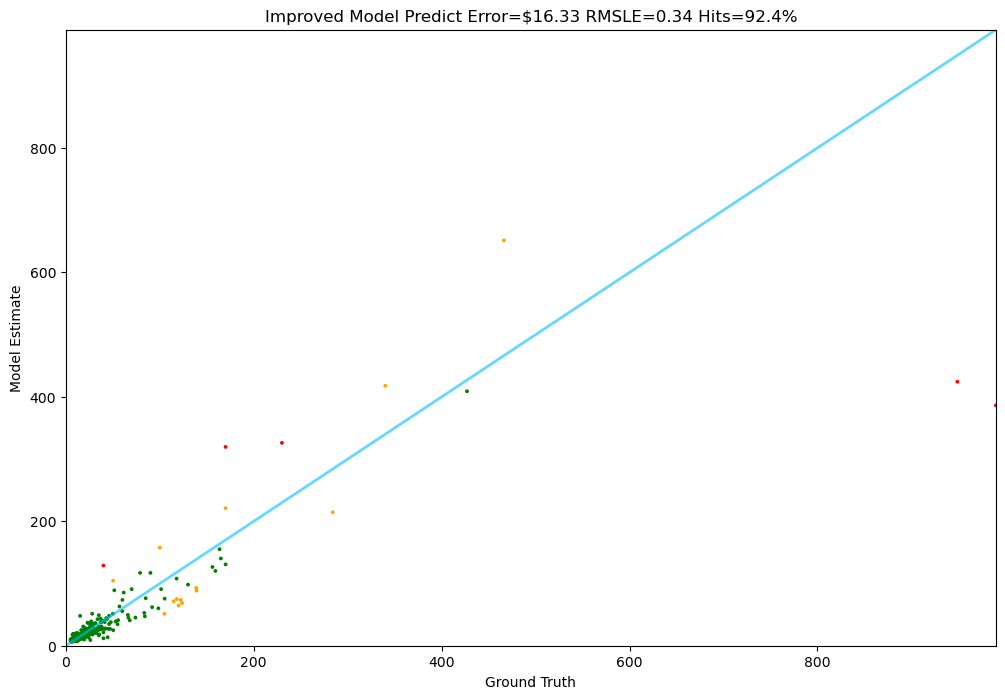

In [19]:
Tester.test(improved_model_predict, test)